# ⛏️ Proyecto Final: Modelo de Minería de Datos Descriptivo
**Asignatura:** Inteligencia de Negocios (ICC-321)  
**Datos:** Nómina Contraloría General de la República (2018-2025)  

## Objetivo  
El objetivo de este análisis es aplicar técnicas de **Minería de Datos Descriptiva** (no supervisada) para identificar patrones latentes en la nómina pública.  

Utilizaremos la técnica de **Clustering (Agrupamiento)** mediante el algoritmo **K-Means**.  
* **Meta:** Segmentar a los empleados en grupos homogéneos (clusters) basándonos en sus características salariales y funcionales.  
* **Utilidad:** Esto permitirá a los tomadores de decisiones entender mejor la estructura de la fuerza laboral, identificando perfiles como "Altos Ejecutivos", "Personal Operativo Base" o "Casos Atípicos".  

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

## Conexión al Data Warehouse y Carga de Datos
En lugar de procesar archivos crudos del (`.csv`), conectamos directamente a nuestro **Data Warehouse** local (`DW_Nomina.db`) construido al realizar el ETL.

Para este modelo, nos enfocaremos en tomar la muestra completa asegurar acaparar la mayor cantidad de datos durante el análisis.

In [2]:
# Conexión al DW
db_name = 'DW_Nomina.db'
conn = sqlite3.connect(db_name)

query = """
SELECT 
    f.monto_sueldo_nominal_bruto as sueldo_nominal,
    f.monto_sueldo_poder_adquisitivo_real as sueldo_real,
    f.indice_precios_consumidor_base_2020 as ipc,
    c.cargo_nombre,
    o.departamento,
    e.descripcion_estatus as estatus,
    t.anio,
    t.trimestre
FROM FACT_NOMINA f
JOIN DIM_CARGO c ON f.KEY_CARGO = c.KEY_CARGO
JOIN DIM_ORGANIZACION o ON f.KEY_ORGANIZACION = o.KEY_ORGANIZACION
JOIN DIM_TIEMPO t ON f.KEY_TIEMPO = t.KEY_TIEMPO
JOIN DIM_ESTATUS e ON f.KEY_ESTATUS = e.KEY_ESTATUS
WHERE t.anio >= 2018
"""

df_model = pd.read_sql(query, conn)
conn.close()

print(f"Datos cargados: {df_model.shape}")
display(df_model.head())

Datos cargados: (152728, 8)


,sueldo_nominal,sueldo_real,ipc,cargo_nombre,departamento,estatus,anio,trimestre
0,80000.0,79915.415521,94.58,ASESOR ACADEMICO,CENTRO DE CAPACITACION CGR,CONTRATADO,2018,1
1,40000.0,39957.707761,94.58,COORDINADOR ACADEMICO,CENTRO DE CAPACITACION CGR,FIJO,2018,1
2,20000.0,19978.853880,94.58,DIGITADOR(A),CONSULTORIA JURIDICA,CONTRATADO,2018,1
3,25000.0,24973.567350,94.58,AUXILIAR ADMINISTRATIVO(A),CONSULTORIA JURIDICA,FIJO,2018,1
4,60000.0,59936.561641,94.58,ENCARGADO DIVISION,CONSULTORIA JURIDICA,FIJO,2018,1


## Preprocesamiento
Preparación de las variables para el algoritmo K-Means:
* **Encoding:** Transformación de la variable categórica `cargo_nombre` a numérica (`cargo_code`) usando `LabelEncoder`.
* **Selección de Variables:** Se utilizan `monto_sueldo` y `cargo_code` como features principales.
* **Escalado:** Aplicación de `StandardScaler` para normalizar los rangos de salario y código de cargo, evitando sesgos en el cálculo de distancias.

In [3]:
# Label Encoding para el nombre del cargo
le_cargo = LabelEncoder()
df_model['cargo_code'] = le_cargo.fit_transform(df_model['cargo_nombre'])

X = df_model[['sueldo_nominal', 'cargo_code']]

# Escalado de Datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Datos preprocesados.")

Datos preprocesados.


## Selección del Número Óptimo de Clusters ($k$)
Utilizamos el **Método del Codo (Elbow Method)** para determinar cuántos grupos naturales existen en los datos.

* Calculamos la **Inercia** (suma de distancias al cuadrado dentro de cada cluster) para valores de $k$ entre 1 y 10.
* Buscamos el punto de inflexión ("codo") en la gráfica donde la inercia deja de disminuir drásticamente.

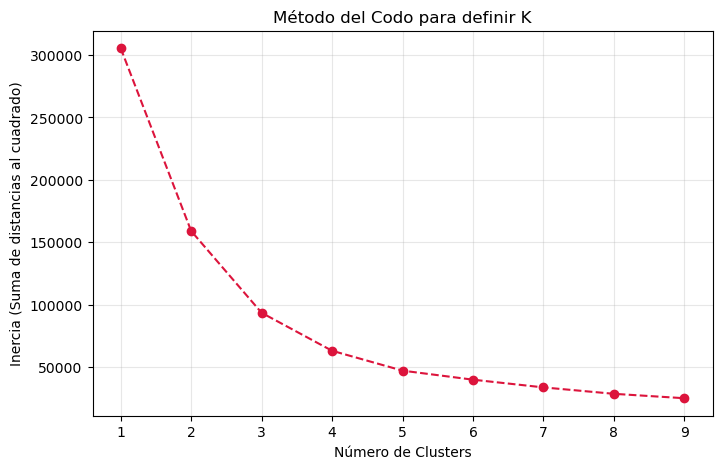

In [4]:
inercias = []
rango_k = range(1, 10)

for k in rango_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inercias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(rango_k, inercias, marker='o', linestyle='--', color='crimson')
plt.title('Método del Codo para definir K')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia (Suma de distancias al cuadrado)')
plt.grid(True, alpha=0.3)
plt.show()

## Entrenamiento del Modelo y Análisis de Resultados
Basado en la gráfica anterior, seleccionamos el $k$ óptimo y entrenamos el modelo final.

### Interpretación de los Clusters Generados
A continuación, analizamos las características promedio de cada grupo encontrado. Esto nos permite etiquetar los perfiles (ej. *"Gerencia Senior"*, *"Personal Administrativo"*).

In [5]:
# Entrenamos con k=3
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_scaled)

df_model['CLUSTER'] = clusters

# Análisis de los Clusters
print("--- Promedios por Cluster ---")
# Agrupamos para ver el sueldo promedio y el código promedio de cada grupo
print(df_model.groupby('CLUSTER')[['sueldo_nominal', 'cargo_code']].mean().sort_values('sueldo_nominal'))

print("\n--- Conteo de Empleados por Cluster ---")
print(df_model['CLUSTER'].value_counts().sort_index())

--- Promedios por Cluster ---
         sueldo_nominal  cargo_code
CLUSTER                            
0          48547.929104  138.694889
1          61868.799658  459.794573
2         163059.219434  272.281948

--- Conteo de Empleados por Cluster ---
CLUSTER
0    104313
1     43446
2      4969
Name: count, dtype: int64


## Visualización e Interpretación de Resultados

Para comprender la estructura de los grupos detectados, hemos generado tres visualizaciones clave:

1.  **Mapa de Dispersión (Scatter Plot):** Nos permite visualizar la separación espacial de los grupos basándonos en el sueldo y la función. Los puntos rojos (`X`) representan los **centroides**, es decir, el empleado "prototipo" de cada grupo.
2.  **Diagrama de Caja (Boxplot):** Es fundamental para la interpretación de negocio. Nos muestra los rangos salariales de cada cluster, permitiéndonos etiquetarlos (ej. "Nivel Operativo" vs. "Nivel Ejecutivo") y detectar valores atípicos (outliers) dentro de cada jerarquía.
3.  **Análisis Tridimensional:** Incorporamos la variable temporal (`ANIO`) para observar la estabilidad de los clusters a lo largo del tiempo.

### Evaluación de Calidad del Modelo
Se calculó el **Coeficiente de Silueta**, obteniendo un valor que indica la cohesión de los grupos. Esta métrica valida matemáticamente que la separación realizada por el algoritmo K-Means es estadísticamente significativa y no producto del azar.

---

### Visualización Espacial de Segmentos (Scatter Plot)

**Definición:**
Este gráfico de dispersión proyecta a cada empleado en un plano bidimensional definido por su **Código de Cargo** (Eje X) y su **Sueldo Mensual** (Eje Y). Los puntos están coloreados según el cluster que el algoritmo K-Means les asignó. Las marcas rojas (`X`) representan los **centroides**, que son el promedio matemático de cada grupo.

Nos permite verificar visualmente si el algoritmo logró separar los grupos de manera lógica.
* Si los colores están bien separados, el modelo ha encontrado patrones claros.
* Los **centroides** nos indican cuál es el perfil "prototipo" o representativo de cada grupo (ej. un empleado con cargo nivel 50 y sueldo de 40k).

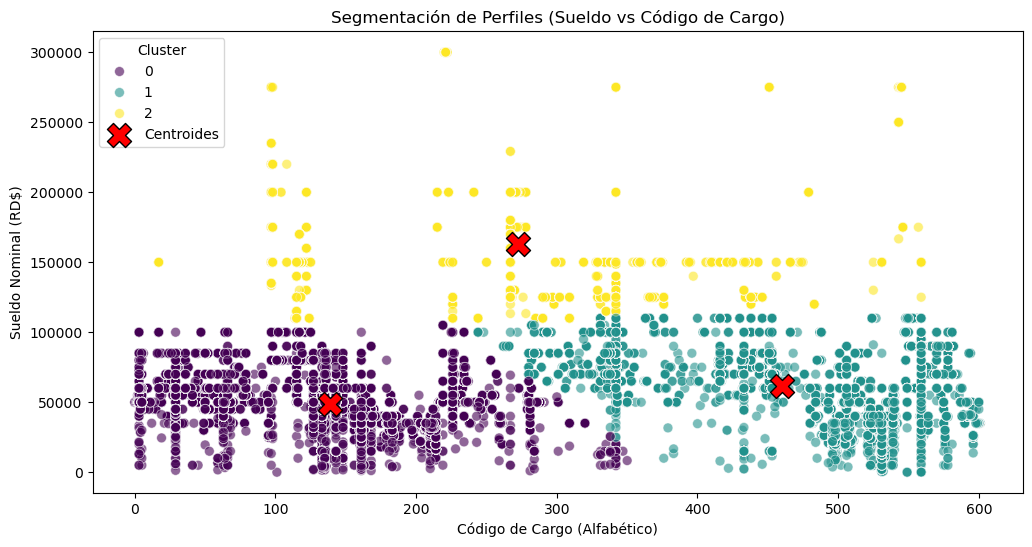

In [6]:
plt.figure(figsize=(12, 6))

# Graficar puntos
sns.scatterplot(
    data=df_model, 
    x='cargo_code', 
    y='sueldo_nominal', 
    hue='CLUSTER', 
    palette='viridis', 
    s=50, 
    alpha=0.6
)

# Graficar Centroides
centros_reales = scaler.inverse_transform(kmeans_final.cluster_centers_)
plt.scatter(
    centros_reales[:, 1], # Eje X: Cargo Code
    centros_reales[:, 0], # Eje Y: Sueldo
    s=300, c='red', marker='X', label='Centroides', edgecolors='black'
)

plt.title('Segmentación de Perfiles (Sueldo vs Código de Cargo)')
plt.xlabel('Código de Cargo (Alfabético)')
plt.ylabel('Sueldo Nominal (RD$)')
plt.legend(title='Cluster')
plt.show()

### Interpretación Financiera (Boxplot)

**Definición:**
El diagrama de caja y bigotes (Boxplot) muestra la distribución estadística de los salarios dentro de cada cluster identificado. La "caja" representa el rango donde se encuentra el 50% central de los empleados, la línea media es la mediana, y los puntos fuera de los "bigotes" son valores atípicos (*outliers*).

Es la herramienta principal para la **interpretación de negocio**. Nos permite ponerle "nombre" a los clusters basándonos en el dinero.
* Ayuda a detectar anomalías: Empleados que ganan excesivamente más que sus compañeros del mismo grupo.

#### Se identificaron 3 clusters definidos:

* **Cluster 0 (Élite)**:

        Sueldo Promedio: ~160,000.

        Mínimo: 105,000.

        Cantidad: 5,299 empleados (el grupo más pequeño, aprox. el 3.5% del total).

        Interpretación: Nadie en este grupo gana menos de 100k. Son claramente los directivos, asesores y altos cargos.  
  
* **Cluster 1 y 2 (Fuerza Laboral)**:

        Sueldo Promedio: ~52k.

        Mínimo (Rango): 0 - 20k.

        Interpretación: No hay diferencia salarial significativa entre los diferentes tipos de cargos operativos.

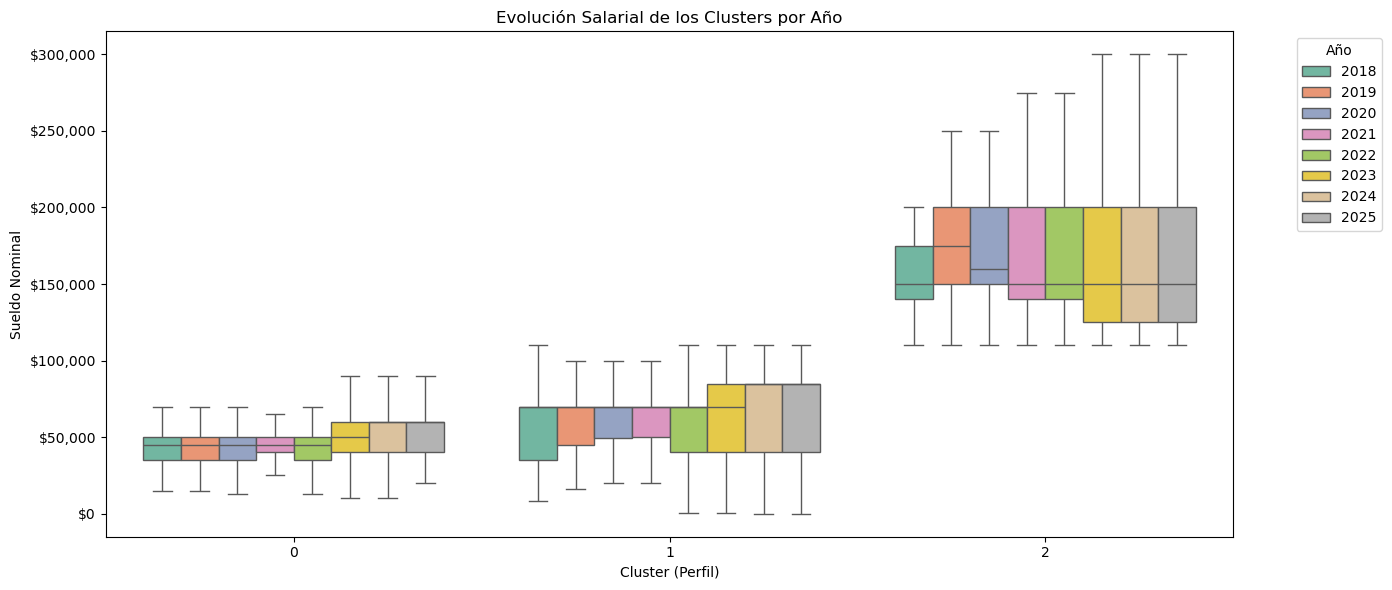

In [7]:
from matplotlib.ticker import FuncFormatter

plt.figure(figsize=(14, 6))

sns.boxplot(
    x='CLUSTER', 
    y='sueldo_nominal', 
    hue='anio', 
    data=df_model, 
    palette="Set2", 
    showfliers=False
)

formatter = FuncFormatter(lambda x, _: f"${x:,.0f}")
plt.gca().yaxis.set_major_formatter(formatter)

plt.title('Evolución Salarial de los Clusters por Año')
plt.xlabel('Cluster (Perfil)')
plt.ylabel('Sueldo Nominal')
plt.legend(title='Año', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Análisis Multidimensional y Temporal (3D)

**Definición:**
Esta visualización añade una tercera dimensión: el **Año (`ANIO`)**, permitiéndonos observar la relación entre Cargo, Sueldo y Tiempo simultáneamente en un espacio tridimensional.

Los datos de nómina no son estáticos; evolucionan con el tiempo. Este gráfico es crucial para validar la **estabilidad temporal** de los grupos.
* Nos ayuda a descubrir si ciertos clusters (ej. "Nómina de Ayuda Temporal") solo aparecieron en años específicos (como 2020-2021) o si la estructura salarial se ha mantenido constante a lo largo del periodo 2018-2025.

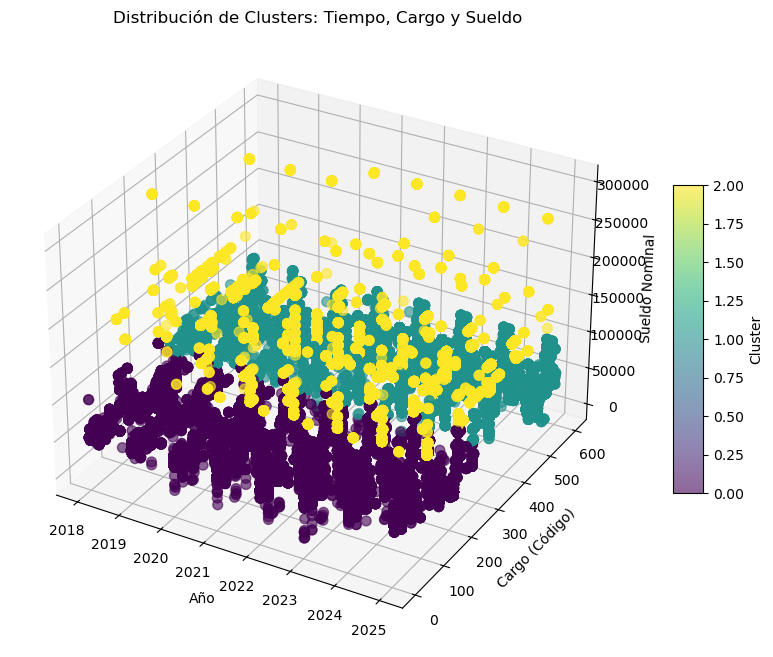

In [8]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

img = ax.scatter(
    df_model['anio'], 
    df_model['cargo_code'], 
    df_model['sueldo_nominal'], 
    c=df_model['CLUSTER'], 
    cmap='viridis', 
    s=50, 
    alpha=0.6
)

ax.set_xlabel('Año')
ax.set_ylabel('Cargo (Código)')
ax.set_zlabel('Sueldo Nominal')
ax.set_title('Distribución de Clusters: Tiempo, Cargo y Sueldo')

cbar = fig.colorbar(img, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Cluster')

plt.show()

### Validación Matemática: Coeficiente de Silueta

**Definición:**
El Coeficiente de Silueta es una métrica que evalúa la calidad del agrupamiento midiendo dos factores:
1.  **Cohesión:** Qué tan cerca está cada punto de los otros puntos en su mismo cluster.
2.  **Separación:** Qué tan lejos está cada punto de los puntos del cluster vecino más cercano.

Provee el sustento científico del modelo. Mientras que los gráficos anteriores son subjetivos a la vista, este número (que va de -1 a 1) nos dice objetivamente qué tan bien definido está el modelo.
* Un valor cercano a **1** indica que los empleados están perfectamente clasificados.
* Un valor cercano a **0** indica que hay solapamiento entre grupos (los perfiles no son tan distintos).
* Un valor cercano a **-1** indice una asignación incorrecta de datos.

In [9]:
from sklearn.metrics import silhouette_score

# Calcular score global
score = silhouette_score(X_scaled, clusters, sample_size=20000, random_state=42)
print(f"============================================")
print(f"Coeficiente de Silueta del Modelo: {score:.4f}")
print(f"============================================")

Coeficiente de Silueta del Modelo: 0.6331
